<a href="https://colab.research.google.com/github/gopaps/MachineLearning/blob/main/week%2015/Anda_Figo_Haq_ClipCrop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP and CROP

**Zero shot cropping of sections from images**


Dalam tutorial berikut, kami mencoba mengekstrak bagian yang terpotong dari gambar menggunakan checkpoint model CLIP dan YOLOS yang dihosting di HuggingFace Hub. Secara umum, untuk memotong bagian dari gambar, kita perlu memilih bagian tersebut secara manual. Namun, di sini kami mencoba mengekstrak bagian hanya dengan menggunakan deskripsi teks.

[**CLIP:**](https://huggingface.co/docs/transformers/model_doc/clip)

CLIP adalah model multi-modal yang memanfaatkan hubungan semantik antara gambar dan deskripsi teks. CLIP memiliki banyak aplikasi lanjutan selain klasifikasi gambar sederhana. Model ini bahkan menjadi katalis bagi model generasi gambar terkenal, DALL-E. CLIP dapat diperluas untuk deteksi objek, pelacakan objek, peringkat gambar, pencarian kesamaan, dan banyak lagi, tergantung pada kreativitas kita. CLIP merupakan terobosan besar karena membuka jalan bagi banyak penelitian di bidang multi-modal AI.

[**YOLOS:**](https://huggingface.co/docs/transformers/model_doc/yolos)

YOLOS (You Only Look at One Sequence) adalah adaptasi dari YOLO pada Vision Transformer (ViT) sederhana untuk deteksi objek, yang terinspirasi oleh DETR. YOLOS-Base, yang langsung diadopsi dari arsitektur BERT-Base, mampu mencapai 42.0 box AP pada benchmark deteksi objek COCO.

## Loading the modules

In [1]:
import os
import torch
import warnings
import requests
import PIL
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import CLIPProcessor, CLIPModel, YolosImageProcessor, YolosForObjectDetection

In [2]:
warnings.simplefilter("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "true"

## Implementation

### Model loading

The following code blocks downloads the relevant model checkpoints from HuggingFace hub (YOLOS and CLIP respectively for object detection and semantic matching of images and text descriptions)

In [3]:
DETECTION_MODEL_NAME = "hustvl/yolos-tiny"
MULTIMODAL_MODEL_NAME = "openai/clip-vit-base-patch16"

**Loading YOLOS model**

In [4]:
det_image_processor = YolosImageProcessor.from_pretrained(DETECTION_MODEL_NAME)
det_model = YolosForObjectDetection.from_pretrained(DETECTION_MODEL_NAME)

preprocessor_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/26.0M [00:00<?, ?B/s]

**Loading the CLIP model**

In [5]:
mm_model = CLIPModel.from_pretrained(MULTIMODAL_MODEL_NAME)
mm_processor = CLIPProcessor.from_pretrained(MULTIMODAL_MODEL_NAME)

config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

### Implementation using loaded modules from HuggingFace hub

The following code blocks dowloads an image and loads it as a PIL Image

In [6]:
url = "https://i.pinimg.com/736x/1b/51/42/1b5142c269f2e9a356202af3f5569a87.jpg"
image = Image.open(requests.get(url, stream=True).raw)

**Code blocks implementing functions responsible for cropping and extraction of images.**

* The *extract_list_images_detected* function detects the objects with confidence scores above the given threshold
* The *extract_image_with_description* function semantically matches with the list of extracted images and descriptions

In [7]:
def extract_list_images_detected(image, prob):
    """
    The function `extract_list_images_detected` takes an image and a probability threshold as input,
    performs object detection on the image using a pre-trained model, and returns a list of cropped
    images of the detected objects along with their corresponding scores.

    Args:
    :param image: The `image` parameter is the input image from which you want to extract the detected
    images. It should be a PIL image object
    :param prob: The parameter "prob" is the probability threshold for filtering out the detected
    objects. It is used to determine which objects are considered significant enough to be included in
    the final list of images. Objects with a probability score higher than the threshold will be
    included, while objects with a lower score will be filtered out

    Returns:
    images_list: returns a list of cropped out images.
    scores: returns a list of confidence scores corresponding scores.
    """

    inputs = det_image_processor(images=image, return_tensors="pt")
    outputs = det_model(**inputs)

    logits = outputs.logits
    bboxes = outputs.pred_boxes
    probas = outputs.logits.softmax(-1)[0, :, :-1]

    keep = probas.max(-1).values > prob
    outs = det_image_processor.post_process(outputs, torch.tensor(image.size[::-1]).unsqueeze(0))
    bboxes_scaled = outs[0]['boxes'][keep].detach().numpy()
    labels = outs[0]['labels'][keep].detach().numpy()
    scores = outs[0]['scores'][keep].detach().numpy()

    images_list = []
    for i,j in enumerate(bboxes_scaled):
        xmin = int(j[0])
        ymin = int(j[1])
        xmax = int(j[2])
        ymax = int(j[3])

        im_arr = np.array(image)
        roi = im_arr[ymin:ymax, xmin:xmax]
        roi_im = Image.fromarray(roi)
        images_list.append(roi_im)

    return images_list, scores

In [8]:
def extract_image_with_description(images_list, text, scores):
    """
    The function `extract_image_with_description` takes a list of images, a text description, and
    scores, and returns the image with the highest score.

    Args:
    images_list: The `images_list` parameter is a list of images. Each image can be represented
    as a file path or a URL
    text: The `text` parameter is a string that represents the description or caption of the
    image
    scores: The "scores" parameter is a list of scores corresponding to each image in the
    "images_list". These scores represent the confidence or relevance of each image to the given text

    Returns:
    the image with the highest score (PIL.Image) and its corresponding score.
    """

    input_ = mm_processor(text = [text], images=images_list , return_tensors="pt", padding=True)
    output = mm_model(**input_)
    logits_per_image = output.logits_per_text
    probs = logits_per_image.softmax(-1)
    l_idx = np.argsort(probs[-1].detach().numpy())[::-1][0:1]

    final_ims = []
    for i,j in enumerate(images_list):
        param_dict = {}
        if i in l_idx:
            param_dict['image'] = images_list[i]
            param_dict['score'] = probs[-1].detach().numpy()[i]
            final_ims.append(param_dict)

    fi = sorted(final_ims, key=lambda item: item.get("score"), reverse=True)
    return fi[0]['image'], fi[0]['score']

## Object Detection using YOLOS

Gets the cropped list of sections of image along with their confidence scores

In [9]:
list_rois, conf_scores = extract_list_images_detected(image, prob=0.85)

`post_process` is deprecated and will be removed in v5 of Transformers, please use `post_process_object_detection` instead, with `threshold=0.` for equivalent results.


## Extraction using CLIP

Viewing the input image using matplotlib

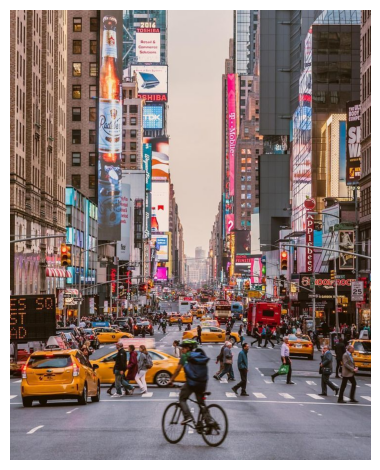

In [10]:
plt.imshow(image)
plt.axis("off")
plt.tight_layout()

Code blocks implementing semantic matching of images with provided descriptions. We provide a list of descriptions for which semantically matched images will be extracted and appended to a dictionary with relevant confidence scores.

In [11]:
TEXT_DESC = ["Man carrying a green bag", "man riding a bicycle", "yellow colored taxi car", "red colored bus"]
images_list = []
for txt in TEXT_DESC:
    img_dict = {}
    img, score = extract_image_with_description(list_rois, txt, conf_scores)
    img_dict['image'] = img
    img_dict['description'] = txt
    img_dict['conf-score'] = score
    images_list.append(img_dict)

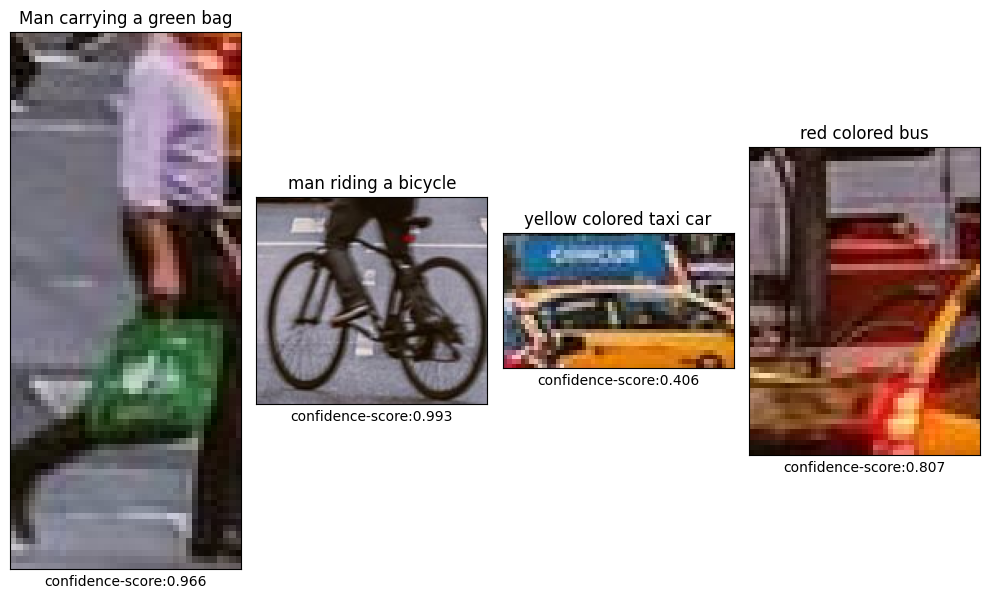

In [12]:
fig = plt.figure(figsize=(10, 20))
for i in range(len(images_list)):
    plt.subplot(1, len(images_list), i + 1)
    plt.imshow(images_list[i]['image'])
    plt.title(images_list[i]['description'])
    plt.xlabel("confidence-score:" + str(round(images_list[i]['conf-score'], 3)))
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])
plt.tight_layout()
plt.show()

## Conclusion

It can be seen that most of the cases could be really efficient as expected, but the drop in accuracy could be visible in other scenarios due to the fact we are leveraging smaller models for inference.